Another simple weather check, threshold changes slightly between seasons
#Season12 dfc["threshold"] = 0.008 - 0.002*dfc["ballpark_fortification"]
#Season13-15 dfc["threshold"] = 0.0085 - 0.002*dfc["ballpark_fortification"]

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

In [2]:
all_files = glob.glob("../roll_data/*-flavor.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# seasons = [11, 12]
seasons = [11,12,13,14]
# seasons = [14]
# seasons = [13, 14]
df = df[df['season'].isin(seasons)]
len(df)

71967

In [3]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]


batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
fielder_params = ['fielder_anticapitalism', 'fielder_chasiness', 'fielder_omniscience', 'fielder_tenaciousness', 'fielder_watchfulness']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']


dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["fort"] = dfc["ballpark_fortification"] - 0.5

X = dfc[["roll", "ballpark_fortification"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=500000, max_iter=5000000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[62541,     5],
       [    5,   457]], dtype=int64)

In [5]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'), (0.002982519919410127, 'ballpark_fortification')]

In [6]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.00882359])

In [7]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

62546
462


In [23]:
fort = dfc["ballpark_fortification"] - 0.5

#Season12 dfc["threshold"] = 0.008 - 0.002*dfc["ballpark_fortification"]
#Season13-15 dfc["threshold"] = 0.0085 - 0.002*dfc["ballpark_fortification"]
dfc["threshold"] = 0.0085 - 0.002*dfc["ballpark_fortification"]

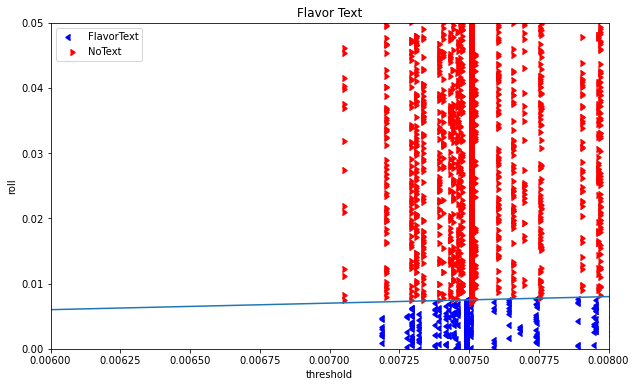

In [24]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="FlavorText", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoText", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Flavor Text")
ax.set_xlim([0.006, 0.008])
ax.set_ylim([0.0, 0.05])
ax.legend()

,offset,weather,event_type,season,roll,threshold,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
9274,-0.000500,Weather.PEANUTS,NoText,11,0.007000,0.0075,Alyssa Harrell,Cory Twelve,ALTERNATE,<NA>,<NA>,O_NO,54,8ec1cd17-8c19-467a-9a7c-493832b42980,248
7586,-0.000390,Weather.PEANUTS,NoText,11,0.007110,0.0075,Sparks Beans,Yosh Carpenter,<NA>,<NA>,<NA>,LOVE,48,c9b93973-e43c-4f9a-ac67-6ff139e5425b,166
8826,-0.000374,Weather.PEANUTS,NoText,11,0.007126,0.0075,Farrell Seagull,Ronan Jaylee,<NA>,<NA>,AFFINITY_FOR_CROWS,<NA>,53,ccf7a61a-7838-47ec-8c67-d27c4cd2d1f3,161
7422,-0.000245,Weather.PEANUTS,NoText,11,0.007255,0.0075,Collins Melon,Marco Escobar,ALTERNATE,<NA>,<NA>,<NA>,47,a20d344d-0da3-4264-ad4f-cd9910c0b913,176
6481,-0.000169,Weather.PEANUTS,NoText,11,0.007331,0.0075,Case Sports,Miguel James,<NA>,<NA>,<NA>,BASE_INSTINCTS,44,ffbf64af-a8bc-4f1e-93dc-13d4ec42e62e,291
1668,-0.000101,Weather.PEANUTS,NoText,11,0.007399,0.0075,Cory Ross,PolkaDot Patterson,SIPHON,SQUIDDISH,<NA>,<NA>,35,739b90e2-04dd-4b82-851a-6696e9ac8359,101


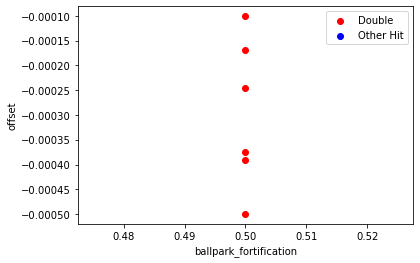

In [25]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_fortification"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Double")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Other Hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "season",
       "roll", "threshold",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [265]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

0.0002648354734513525
0.9994472809302016
